In [1]:
from __future__ import division

import math
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import numpy as np
import time
from numpy import arange, sin, pi, random

from pyspark import SparkContext

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Anomaly"]
lookback = 3

In [2]:
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util import common
from bigdl.util.common import *

sc = SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))
init_engine()

In [3]:
import os

## for running on cluster
data_file_path = os.getenv("DATA_FILE_NAME")
generation_complete_file_path = os.getenv("GENERATION_COMPLETE_FILE_NAME")
model_pb_file_path = os.getenv("MODEL_PB_FILE_NAME")
model_attrib_file_path = os.getenv("MODEL_ATTRIB_FILE_NAME")

## for local runs possibly these will not be set in the environment
if not data_file_path:
    data_file_path = 'data/CPU_examples.csv'

if not generation_complete_file_path:
    generation_complete_file_path = '/tmp/data_preparation_complete.txt'
    
if not model_pb_file_path:
    model_pb_file_path = '/tmp/model.pb'
    
if not model_attrib_file_path:
    model_attrib_file_path = '/tmp/model-attributes.properties'

local_model_file_path = '/tmp/model.bigdl'
local_model_weights_file_path = '/tmp/model.bin'

print(data_file_path)
print(generation_complete_file_path)
print(model_pb_file_path)
print(model_attrib_file_path)

data/CPU_examples.csv
/tmp/data_preparation_complete.txt
/tmp/model.pb
/tmp/model-attributes.properties


## Read data from csv

In [4]:
df = pd.read_csv(data_file_path)

In [5]:
df.shape

(100001, 3)

In [6]:
df.head()

,Time,CPU,Class
0,0,0.441271,0
1,1,0.400604,0
2,2,0.330440,0
3,3,0.227240,0
4,4,0.328483,0


## Basic sanity check of data and normalization

In [7]:
# check for null data
df.isnull().values.any()

# Standard scaling : mean 0, stddev 1
scaler = preprocessing.StandardScaler()
df['CPU'] = scaler.fit_transform(df['CPU'].values.reshape(-1, 1))

scaler_mean = scaler.mean_
scaler_var = scaler.var_ ** 0.5

print(scaler_mean)  ## mean
print(scaler_var)   ## std dev

df.head()

[0.34964777]
[0.18103937]


,Time,CPU,Class
0,0,0.506097,0
1,1,0.281467,0
2,2,-0.106098,0
3,3,-0.676137,0
4,4,-0.116907,0


<bound method Series.count of 0    83441
1    16560
Name: Class, dtype: int64>


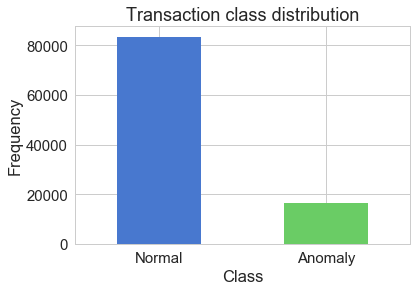

In [8]:
# let's explore the distribution of input data
count_classes = pd.value_counts(df['Class'], sort = False)
print(count_classes.count)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [9]:
# Just checking the relative counts
anomaly = df[df.Class == 1]
normal = df[df.Class == 0]

anomaly.shape

(16560, 3)

In [10]:
normal.shape

(83441, 3)

In [11]:
anomaly.CPU.describe()

count    16560.000000
mean         1.381443
std          0.547092
min         -0.812502
25%          1.013223
50%          1.383492
75%          1.751278
max          3.658377
Name: CPU, dtype: float64

In [12]:
normal.CPU.describe()

count    83441.000000
mean        -0.274166
std          0.827745
min         -4.338766
25%         -0.835627
50%         -0.273015
75%          0.287959
max          3.306589
Name: CPU, dtype: float64

## Any correlation between time and CPU metrics ?

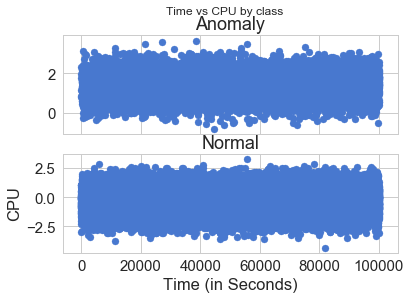

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time vs CPU by class')

ax1.scatter(anomaly.Time, anomaly.CPU)
ax1.set_title('Anomaly')

ax2.scatter(normal.Time, normal.CPU)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('CPU')
plt.show()

## Feature Re-engineering

In [14]:
def widenX(width, x) :
    slicestart = 0
    sliceend = width

    X_data = []
    newlength = x.size - width + 1
    for i in range(newlength):
        X_data.append(x[slicestart:sliceend])
        slicestart = slicestart + 1
        sliceend = sliceend + 1

    return np.reshape(X_data, newshape=(newlength, width))

def widenY(width, y):
    return y[width-1:]

In [15]:
df.head()
anomaly = df[df.Class == 1]
anomaly.shape

(16560, 3)

In [16]:
X_train = widenX(lookback, df['CPU'])
X_train.shape

(99999, 3)

In [17]:
Y_train = widenY(lookback, df['Class'])
Y_train.shape

(99999,)

In [18]:
class_0 = list(filter(lambda x: x == 0.0, Y_train)) 
class_1 = list(filter(lambda x: x == 1.0, Y_train)) 
print(len(class_0), len(class_1))

83439 16560


## Split into training and test set

In [19]:
original_X_train_size = X_train.shape[0]
train_set_size = int(0.8 * original_X_train_size)
test_set_size = original_X_train_size - train_set_size

X_test = X_train[original_X_train_size - test_set_size : -1]
X_train = X_train[0 : train_set_size]

Y_test = Y_train[original_X_train_size - test_set_size : -1]
Y_train = Y_train[0 : train_set_size]

print(int(train_set_size))
print(int(test_set_size))
print(X_train.shape)
print(X_test.shape)

79999
20000
(79999, 3)
(19999, 3)


In [20]:
X_train.shape

(79999, 3)

In [21]:
X_test.shape

(19999, 3)

In order to get data into BigDL engine we need to convert the numpy arrays into Spark RDD. Here's a helper function that does this. Note that we will use negative log likelihood for loss computation - hence based on the documentation of BigDL, the labels need to start from 1. Hence we add a 1 in the function below to all the labels.

In [22]:
def get_rdd_from_ndarray(sc):
    rdd_X_train = sc.parallelize(X_train)
    rdd_Y_train = sc.parallelize(Y_train)
    rdd_X_test = sc.parallelize(X_test)
    rdd_Y_test = sc.parallelize(Y_test)

    rdd_train_sample = rdd_X_train.zip(rdd_Y_train).map(lambda labeledFeatures:
                                       common.Sample.from_ndarray(labeledFeatures[0], labeledFeatures[1]+1))
    rdd_test_sample = rdd_X_test.zip(rdd_Y_test).map(lambda labeledFeatures:
                                     common.Sample.from_ndarray(labeledFeatures[0], labeledFeatures[1]+1))
    return (rdd_train_sample, rdd_test_sample)

(train_data, test_data) = get_rdd_from_ndarray(sc)

# Build the Model

In [23]:
# create a graph model
def make_new_model(X_train):

    ## input layer with relu and dropout
    initial = Linear(X_train.shape[1], 16).set_name("input")()
    relu1 = ReLU()(initial)
    dropout1 = Dropout(0.3)(relu1)

    ## first hidden layer with relu and dropout
    hidden1 = Linear(16, 32)(dropout1)
    relu2 = ReLU()(hidden1)
    dropout2 = Dropout(0.4)(relu2)

    ## second hidden layer with relu and dropout
    hidden2 = Linear(32, 32)(dropout2)
    relu3 = ReLU()(hidden2)
    dropout3 = Dropout(0.4)(relu3)

    ## output layer with softmax(2) and dropout
    output = Linear(32, 2)(dropout3)
    softmax = SoftMax().set_name("output")(output)

    return Model([initial], [softmax])

In [24]:
if (os.path.exists(local_model_file_path) and os.path.exists(local_model_weights_file_path)):
    print("Got existing model .. loading ..")
    model = Model.loadModel(local_model_file_path, local_model_weights_file_path) # load from local fs
else:
    model = make_new_model(X_train)

Got existing model .. loading ..


## Optimize and Train

In [25]:
learning_rate = 0.001
training_epochs = 8
batch_size = 256

optimizer = Optimizer(
    model = model,
    training_rdd = train_data,
    criterion = ClassNLLCriterion(),
    optim_method = Adam(learningrate=learning_rate),
    end_trigger = MaxEpoch(training_epochs),
    batch_size = batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size = batch_size,
    val_rdd = test_data,
    trigger = EveryEpoch(),
    val_method = [Top1Accuracy()]
)

log_dir = 'mylogdir'

app_name='anomaly-cpu-' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir=log_dir, app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir=log_dir, app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ", app_name)

creating: createClassNLLCriterion
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  anomaly-cpu-20180722-021348


In [26]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 4.51 ms, sys: 2.37 ms, total: 6.88 ms
Wall time: 34.4 s


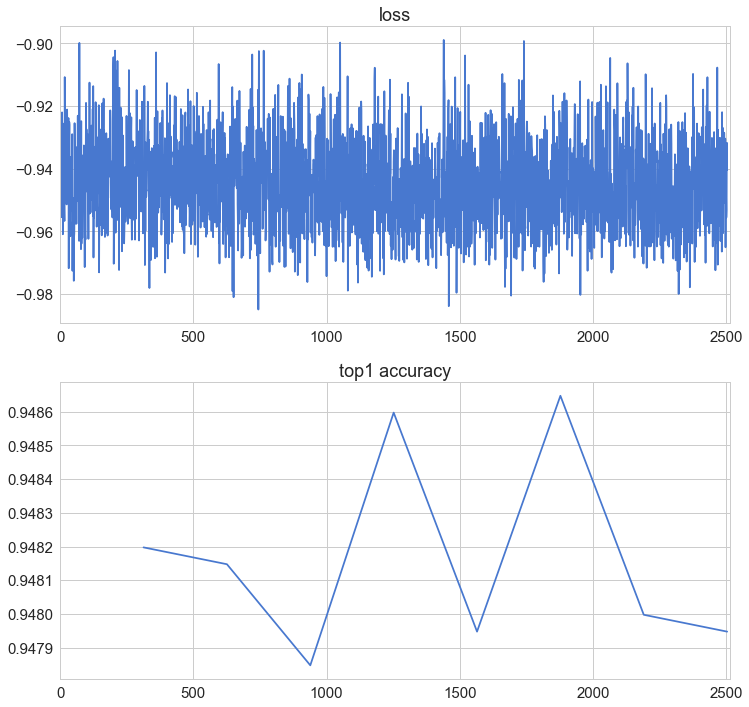

In [27]:
# save BigDL model locally
model.saveModel(local_model_file_path, local_model_weights_file_path, True) # save to local fs

# model.save_tensorflow([("input", [1, 3])], "/tmp/model.pb")
model.save_tensorflow([("input", [1, 3])], model_pb_file_path)

loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)


# Predict on test set

In [28]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return int(l[0] - 1)

In [29]:
predictions = trained_model.predict(test_data)

In [30]:
%%time
predictions = trained_model.predict(test_data)
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(50)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(50)))

Ground Truth labels:
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1
Predicted labels:
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1
CPU times: user 11.4 ms, sys: 3.21 ms, total: 14.6 ms
Wall time: 128 ms


In [31]:
labels = [map_groundtruth_label(s.label.to_ndarray()) for s in test_data.take(20000)]
df_prediction = pd.DataFrame({'Real Class' :np.array(labels)})
predicted_labels = [map_predict_label(s) for s in predictions.take(20000)]
df_prediction['Prediction'] = predicted_labels

In [32]:
total_size = X_test.shape[0]
mismatch_size = df_prediction[ df_prediction['Real Class'] != df_prediction['Prediction'] ].size
accuracy = ((total_size - mismatch_size) / total_size) * 100
print(total_size)
print(mismatch_size)
print(accuracy)

19999
2080
89.5994799739987


In [33]:
import datetime
now = datetime.datetime.now()

# with open("/tmp/model-attrib.properties", "w") as fp:
with open(model_attrib_file_path, "w") as fp:
    fp.write("width=" + str(lookback) + "\n")
    fp.write("mean=" + str(scaler_mean[0]) + "\n")
    fp.write("std=" + str(scaler_var[0]) + "\n")
    fp.write("input=input\n")
    fp.write("output=output\n")
    fp.write("generatedAt=" + str(datetime.datetime.now()) + "\n")

In [34]:
with open(generation_complete_file_path, "w") as fp:
    fp.write(str(datetime.datetime.now()))

## Predict on a new dataset

In [35]:
df = pd.read_csv("data/CPU_examples_test.csv")

## standardize and widen
df['CPU'] = df['CPU'].apply(lambda x: (x - scaler_mean) / scaler_var)
X_test = widenX(lookback, df['CPU'])
Y_test = widenY(lookback, df['Class'])

print(X_test.shape)
anomaly = df[df.Class == 1]
anomaly.shape

(49999, 3)


(8365, 3)

In [36]:
def get_rdd_from_ndarray_test(sc):
    rdd_X_test = sc.parallelize(X_test)
    rdd_Y_test = sc.parallelize(Y_test)

    rdd_test_sample = rdd_X_test.zip(rdd_Y_test).map(lambda labeledFeatures:
                                     common.Sample.from_ndarray(labeledFeatures[0], labeledFeatures[1]+1))
    return rdd_test_sample

test_data = get_rdd_from_ndarray_test(sc)

In [37]:
%%time
predictions = trained_model.predict(test_data)
print('Ground Truth labels:')
print(', '.join(str(map_groundtruth_label(s.label.to_ndarray())) for s in test_data.take(50)))
print('Predicted labels:')
print(', '.join(str(map_predict_label(s)) for s in predictions.take(50)))

Ground Truth labels:
0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
Predicted labels:
0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
CPU times: user 13.5 ms, sys: 3.43 ms, total: 16.9 ms
Wall time: 141 ms


In [38]:
labels = [map_groundtruth_label(s.label.to_ndarray()) for s in test_data.take(X_test.shape[0])]
df_prediction = pd.DataFrame({'Real Class' :np.array(labels)})
predicted_labels = [map_predict_label(s) for s in predictions.take(X_test.shape[0])]
df_prediction['Prediction'] = predicted_labels

In [39]:
total_size = X_test.shape[0]
mismatch_size = df_prediction[ df_prediction['Real Class'] != df_prediction['Prediction'] ].size
accuracy = ((total_size - mismatch_size) / total_size) * 100
print(total_size)
print(mismatch_size)
print(accuracy)

49999
5290
89.41978839576792
